# Text to JSON

In [1]:
import json, pandas as pd

In [ ]:
with open('Mikhail_Bulgakov__Master_i_Margarita.txt') as file:
  reader = file.read()

In [ ]:
text = reader.split('ЧАСТЬ')

In [ ]:
chapters_1 = text[1].split('Глава')
chapters_2 = text[2].split('Глава')

In [ ]:
def parse_chapter(ch):
  data = ch.split('\n')
  return (data[0].strip(' '), data[1], data[2:])

In [ ]:
book_dict = {}

for c in chapters_1[1:]:
  inf = parse_chapter(c)
  book_dict['_'.join([inf[0], inf[1]])] = inf[2]

for h in chapters_2[1:]:
  inf = parse_chapter(h)
  book_dict['_'.join([inf[0], inf[1]])] = inf[2]

In [ ]:
with open("book.json", "w", encoding='utf-8') as outfile:
    json.dump(book_dict, outfile, ensure_ascii=False, indent=4)

Загрузка созданных файлов

In [42]:
with open("book.json", "r", encoding='utf-8') as file:
    book_dict = json.load(file)

In [ ]:
locations = pd.read_excel("toponyms.xlsx", sheet_name='all toponyms')

In [ ]:
toponyms = list(locations['toponyms'])

# Spacy

In [ ]:
!pip install spacy
import spacy
!python -m spacy download ru_core_news_sm
nlp = spacy.load("ru_core_news_sm")

# DeepPavlov

In [ ]:
!pip install deeppavlov
from deeppavlov import build_model

ner_model = build_model('ner_collection3_bert', download=True, install=True)

In [ ]:
!pip3 install seaborn
!pip3 install matplotlib
import seaborn as sns
import matplotlib
from pathlib import Path
from matplotlib import pyplot as plt

In [ ]:
!pip install pymorphy2
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

In [9]:
import string
from collections import defaultdict, Counter

In [ ]:
def get_ents(ner_res):
  entities = []
  for token_sent, tag_sent in zip(ner_res[0], ner_res[1]):
    for token, tag in zip(token_sent, tag_sent):
      if tag != 'O':
        entities.append((token, tag))
  return entities

In [ ]:
def join_bio(entities):
  ents = []
  temp_entity = []
  for word, tag in entities:
      if tag.startswith('B-') or tag.startswith('S-') and word not in string.punctuation:
          if temp_entity:
              ents.append((" ".join(temp_entity), tag_name))
              temp_entity = []
          tag_name = tag[-3:]
          temp_entity.append(word)
      else:
          temp_entity.append(word)

  if temp_entity:
      ents.append((" ".join(temp_entity), tag_name))
  return ents


In [ ]:
def idx_to_pop(lst):
  idx_pop = []
  new_lst = []
  for idx, e in enumerate(lst):
    if e[0][-1] == '-':
      new_lst.append((' '.join([e[0], lst[idx + 1][0]]), e[1]))
      idx_pop.append(idx + 1)
    else:
      new_lst.append(e)
  for i in sorted(idx_pop, reverse=True):
    new_lst.pop(i)
  return new_lst

In [ ]:
def dict_count(ents):
  norm_dict = defaultdict(list)
  for e in ents:
    k = ' '.join([morph.parse(el)[0].normal_form for el in e[0].split(' ')])
    norm_dict[(k, e[1])].append(e[0])

  common_dict = {}
  for key, value in norm_dict.items():
      key_found = False
      for k in norm_dict.keys():
          common = list((Counter(key[0].split()) & Counter(list(k[0].split()))).elements())
          if len(common) > 0 and len(common) != len([True for c in common if c in toponyms]):
              common_dict[k] = common_dict.get(k, []) + value
              key_found = True
              break
      if not key_found:
          common_dict[key] = common_dict.get(key, []) + value

  freq_dict = {key: len(common_dict[key]) for key in common_dict}
  freq_dict = {k: v for k, v in sorted(freq_dict.items(), key=lambda item: item[1], reverse=True)}
  freq_dict = {'_'.join([k[0], k[1]]): v for k, v in freq_dict.items()}
  return freq_dict

## Book parsing

In [ ]:
from tqdm import tqdm

In [ ]:
not_ner = ['мастер', 'кот', 'регент']

In [ ]:
# ner по книге

book_ents_1 = []
for k in tqdm(book_dict):
  ner_ents = get_ents(ner_model(book_dict[k]))
  jointed = join_bio(ner_ents)
  popped = idx_to_pop(jointed)
  clean_ents = [e[0].strip('.,!?:') if len(e[0]) > 2 else e for e in popped]
  ent_dict = dict_count(clean_ents)
  book_ents_1.append(ent_dict)

100%|██████████| 32/32 [1:16:23<00:00, 143.23s/it]


In [ ]:
with open("deeppavlov_ents.json", "w", encoding='utf-8') as outfile:
    json.dump(book_ents_1, outfile, ensure_ascii=False, indent=4)

In [ ]:
# для мастера кота и регента

book_ents_2 = []
for k in tqdm(book_dict):
  doc = nlp(' '.join(book_dict[k]))
  lemmas = [token.lemma_ for token in doc]
  ent_dict = {}
  for obj in not_ner:
    if obj in lemmas:
      ent_dict[obj] = lemmas.count(obj)
  book_ents_2.append({k:ent_dict})

100%|██████████| 32/32 [01:19<00:00,  2.49s/it]


## Unite entities 2.0



In [ ]:
!pip install fuzzywuzzy
!pip install python-Levenshtein
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

In [ ]:
with open("deeppavlov_ents.json", "r", encoding='utf-8') as outfile:
    deeppavlov_ents = json.load(outfile)

In [ ]:
# уникальные сущности по всей книге
set_ents = []
for d in deeppavlov_ents:
  set_ents.extend(list(d.keys()))

set_ents = set(set_ents)

In [ ]:
mapping = ["михаил александрович берлиоз",
           "наташа прокофьевич",
           "иешуа га - ноцрить",
           "иван николаевич бездомный",
           "григорий данилович римский",
           "иван савелиевич варенуха",
           "понтий пилат",
           "александр николаевич стравинский",
           "андрей фокич соков",
           "фагот коровьев",
           "никанор иванович босой",
           "степан богданович лиходеев",
           "маргарита",
           "марк крысобой",
           "максимилиан андреевич поплавский",
           'садовый улица',
           'патриарший пруд',
           'бронный улица',
           'грибоедовский дом',
           'кот бегемот']

In [ ]:
# создание словаря ближайших наименований
auto_mapping = {}
for k in mapping:
  close_to = process.extract(k, list(set_ents), limit=10)
  close_to = [t[0] for t in close_to if t[1]>77]
  auto_mapping[k] = close_to

In [ ]:
values = []
for v in auto_mapping.values():
  for va in v:
    values.append(va)


In [ ]:
def corresponding_key(val, dictionary):
  for k, v in dictionary.items():
    if val in v:
      return k

In [ ]:
new_deeppavlov_ents = []
for d in deeppavlov_ents:
  new_d = defaultdict(list)
  for k in d.keys():
    if k in values:
      new_key = corresponding_key(k, auto_mapping)
      new_d[new_key].append(d[k])
    else:
      new_d[k].append(d[k])
  new_d = {key: sum(new_d[key]) for key in new_d}
  new_d = {k: v for k, v in sorted(new_d.items(), key=lambda item: item[1], reverse=True)}
  new_deeppavlov_ents.append(new_d)

## Dice and Cosine

In [ ]:
!pip3 install seaborn
!pip3 install matplotlib
import seaborn as sns
import matplotlib
from pathlib import Path
from matplotlib import pyplot as plt

In [2]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

In [3]:
!pip install networkx
import networkx as nx

In [6]:
import itertools

combs = itertools.combinations(new_deeppavlov_ents, 2)
combs = list(combs)

In [7]:
def cosine(chp_tuple):
    all_keys = list(set(chp_tuple[0].keys()).union(set(chp_tuple[1].keys())))

    chapter1_vector = [chp_tuple[0].get(key, 0) for key in all_keys]
    chapter2_vector = [chp_tuple[1].get(key, 0) for key in all_keys]

    chapter1_vector = np.array(chapter1_vector).reshape(1, -1)
    chapter2_vector = np.array(chapter2_vector).reshape(1, -1)

    cosine_sim = cosine_similarity(chapter1_vector, chapter2_vector)[0][0]

    return cosine_sim

In [10]:
elist_dice=[]
for c, chapter in zip(combs, list(itertools.combinations(list(range(1, len(new_deeppavlov_ents)+1)), 2))):
  common_items = list((Counter(c[0].keys()) & Counter(c[1].keys())).elements())
  dice = len(common_items)*2 / (len(c[0].keys()) + len(c[1].keys()))
  elist_dice.append((chapter[0], chapter[1], dice))


In [15]:
G=nx.Graph()
G.add_weighted_edges_from(elist_dice)
communities_dice = nx.community.louvain_communities(G)
communities_dice

[{2, 16, 25, 26},
 {1, 3, 4, 5, 6, 8, 11, 13},
 {7, 9, 10, 12, 14, 15, 17, 18, 27, 28, 32},
 {19, 20, 21, 22, 23, 24, 29, 30, 31}]

In [14]:
elist_cosine=[]
for c, chapter in zip(combs, list(itertools.combinations(list(range(1, len(new_deeppavlov_ents)+1)), 2))):
  elist_cosine.append((chapter[0], chapter[1], cosine(c)))

In [ ]:
G=nx.Graph()
G.add_weighted_edges_from(elist_cosine)
communities_cosine = nx.community.louvain_communities(G, resolution=2)
communities_cosine

[{2, 16, 25, 26},
 {9, 15},
 {7, 10, 14, 17, 27},
 {1, 3, 4, 5, 6, 8, 11, 13},
 {19, 20, 21, 22, 23, 30},
 {12, 18, 28, 29},
 {24, 31},
 {32}]

In [ ]:
# столбцы и строки для heatmap для графа по elist_dice
index_column = []
for s in communities_dice:
  index_column.extend(sorted(list(s)))

arr = []
for k1 in index_column:
    row = []
    for k2 in index_column:
      common = list((Counter(new_deeppavlov_ents[k1-1].keys()) & Counter(new_deeppavlov_ents[k2-1].keys())).elements())
      dice_me = len(common)*2 / (len(new_deeppavlov_ents[k1-1].keys()) + len(new_deeppavlov_ents[k2-1].keys()))
      row.append(dice_me)
    arr.append(row)

table = pd.DataFrame(data=arr, index=index_column, columns=index_column)

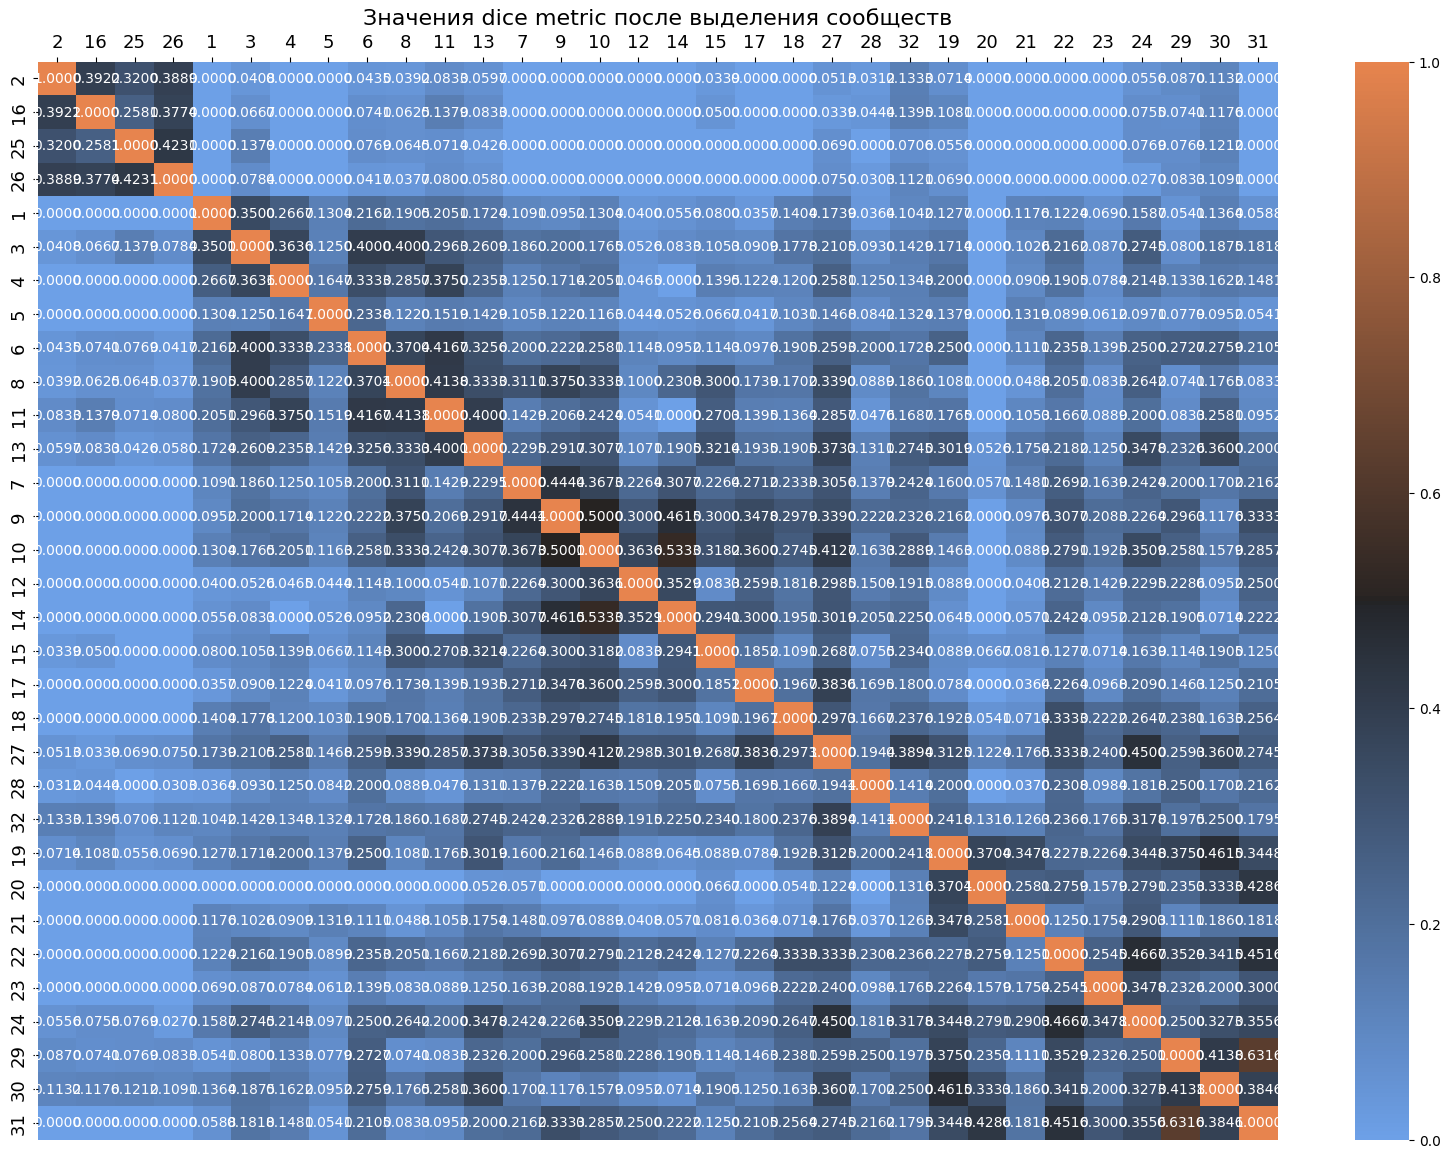

In [ ]:
plt.figure(figsize = (20,14))
ax = sns.heatmap(table, annot = True, fmt=".4f", cmap=sns.diverging_palette(250, 30, l=65, center="dark", as_cmap=True))
ax.set(xlabel="", ylabel="")
ax.xaxis.tick_top()
plt.tick_params(axis='both', which='major', labelsize=13)
plt.title('Значения dice metric после выделения сообществ', fontsize=16)
# plt.savefig('heatmap.png')
plt.show()

In [16]:
# для того, чтобы выделить сообщества разными цветами
# первые 4 цвета для графа по elist_dice
# все 8 цветов для графа по elist_cosine

colors = ['#FFC5C5','#F0DBAF','#C7DCA7','#89B9AD']#'#fae6f0','#7f91b6','#ccd3e1','#5cd6fb']
color_map = []
for node in G.nodes():
   for i in range(len(communities_dice)):
      if node in communities_dice[i]:
         color_map.append(colors[i])

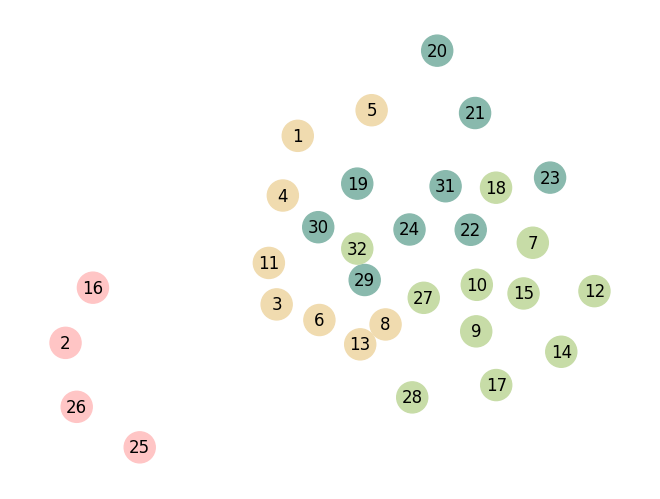

In [38]:
nx.draw(G, node_color=color_map, edge_color='#ffffff', node_size=500, with_labels=True)

In [39]:
community_0 = []
community_1 = []
community_2 = []
community_3 = []

for l in elist_dice:
  if l[0] in communities_dice[0] and l[1] in communities_dice[0]:
    community_0.append((l[0], l[1], round(l[2], 3)))
  elif l[0] in communities_dice[1] and l[1] in communities_dice[1]:
    community_1.append((l[0], l[1], round(l[2], 3)))
  elif l[0] in communities_dice[2] and l[1] in communities_dice[2]:
    community_2.append((l[0], l[1], round(l[2], 3)))
  elif l[0] in communities_dice[3] and l[1] in communities_dice[3]:
    community_3.append((l[0], l[1], round(l[2], 3)))

In [43]:
# вывод названий глав для графов

chapters = []
for c in community_0:
  chapters.append((list(book_dict.keys())[c[0] - 1], list(book_dict.keys())[c[1] - 1], c[2]))

chapters

[('2_Понтий Пилат', '16_Казнь', 0.392),
 ('2_Понтий Пилат', '25_Как прокуратор пытался спасти Иуду', 0.32),
 ('2_Понтий Пилат', '26_Погребение', 0.389),
 ('16_Казнь', '25_Как прокуратор пытался спасти Иуду', 0.258),
 ('16_Казнь', '26_Погребение', 0.377),
 ('25_Как прокуратор пытался спасти Иуду', '26_Погребение', 0.423)]

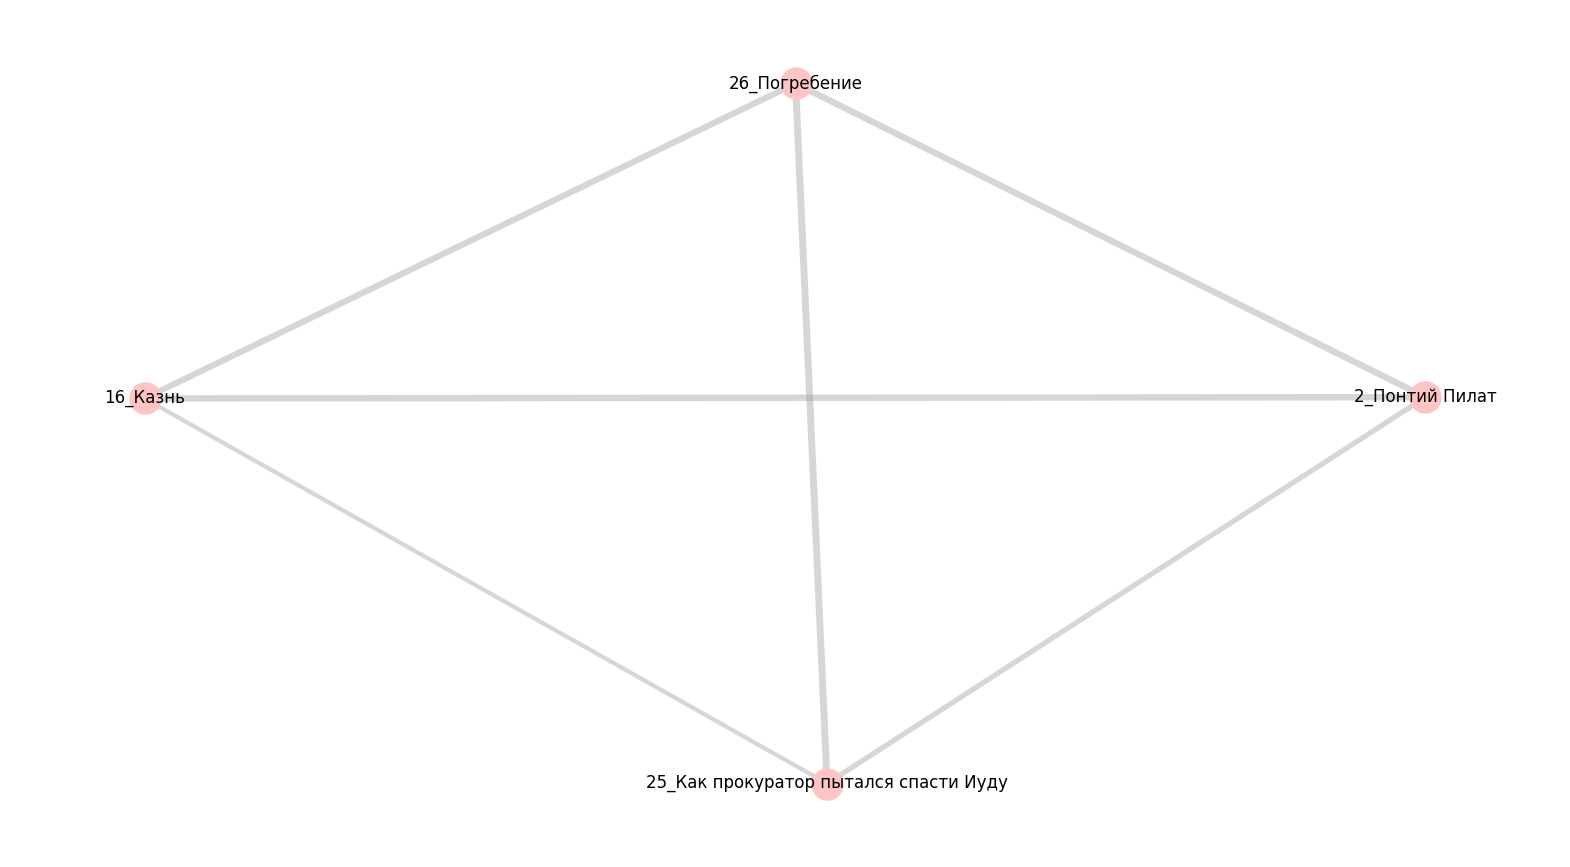

In [46]:
G = nx.Graph()
G.add_weighted_edges_from(chapters)

pos = nx.spring_layout(G)

plt.figure(figsize=(20, 11))
# веса ребер
weights = [d['weight'] for (u, v, d) in G.edges(data=True)]

# масштабирование весов
max_weight = max(weights)
normalized_weights = [5 * (w / max_weight) for w in weights]

nx.draw_networkx_nodes(G, pos, node_color='#FFC5C5', node_size=500)

nx.draw_networkx_edges(G, pos, width=normalized_weights, alpha=0.4, edge_color='#999999')

nx.draw_networkx_labels(G, pos)

plt.axis('off')
plt.show()